In [2]:
from google.colab import auth
auth.authenticate_user()

import sys
from google.colab import drive
drive.mount('/content/gdrive')

% cd '/content/gdrive/My Drive/Colab Notebooks/AlexNet/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/AlexNet


https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [5]:
from IPython.display import Image
Image('AlexNet_Structure.png')

In [4]:
import os
os.listdir()

['AlexNet_Structure.PNG', 'AlexNet_Pytorch.ipynb']

In [0]:
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [0]:
train_dir = '../imagenet_data/train/'
val_dir = '../imagenet_data/val/'

In [0]:
image_datasets = {
    'train': ImageFolder(train_dir, transform=transforms.ToTensor()),
    'val': ImageFolder(val_dir, transform=transforms.ToTensor()),
}

In [0]:
trainloader = DataLoader(
    image_datasets['train'],
    batch_size=10,
    shuffle=False
)

testloader = DataLoader(
    image_datasets['val'],
    batch_size=10,
    shuffle=False
)

In [10]:
mean = 0.0

for img,_ in image_datasets['train']:
    mean += img.mean([1,2])
    img = (img - mean.unsqueeze(1).unsqueeze(1))**2

mean = mean/len(image_datasets['train'])

sumel = 0.0
countel = 0
for img, _ in image_datasets['train']:
    img = (img - mean.unsqueeze(1).unsqueeze(1))**2
    sumel += img.sum([1, 2])
    countel += torch.numel(img[0])
std = torch.sqrt(sumel/countel)


print(mean, std)
# tensor([0.3749, 0.3992, 0.4505])

tensor([0.5143, 0.4760, 0.3487]) tensor([0.2776, 0.2575, 0.2865])


In [0]:
size = 224
batch_size = 32
num_workers = 1

mean = np.array([0.514, 0.476, 0.349])
std = np.array([0.278, 0.258, 0.287])
#mean=[0.485, 0.456, 0.406]
#std=[0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
}

image_datasets = {
    'train': ImageFolder(train_dir, transform=data_transforms['train']),
    'val': ImageFolder(val_dir, transform=data_transforms['val']),
}

data_loader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=num_workers) for x in ['train', 'val']
}

tensor([1, 0, 1, 0])


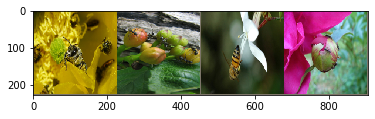

In [49]:
# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.514, 0.476, 0.349])
    std = np.array([0.278, 0.258, 0.287])

    #mean=[0.485, 0.456, 0.406]
    #std=[0.229, 0.224, 0.225]
    
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(data_loader['train']))
grid_img = make_grid(images[:4], nrow=4)
print(labels[:4])
imshow(grid_img)

In [44]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.conv_base=nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, padding=2, stride=4, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.fc_base=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.fc_base(x)
        return x
    
model = AlexNet()
model

AlexNet(
  (conv_base): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_siz

In [0]:
criterio=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
device=torch.device('cuda')
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
NUM_EPOCHS=1000

In [16]:
device

device(type='cuda')

In [0]:
model=model.to(device)

In [59]:
model.train()
for epoch in range(NUM_EPOCHS):
    lr_scheduler.step()
    for imgs, classes in data_loader['train']:
        imgs, classes=imgs.to(device), classes.to(device)
        outputs = model(imgs)

        loss = criterio(outputs, classes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        #print(preds)

    if epoch%10 == 0:
        print('Epoch {}: Loss = {} Accuracy = {} '.format(epoch+1, loss.item(),torch.sum(preds == classes).item()/batch_size))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1: Loss = 6797.41259765625 Accuracy = 0.4375 
Epoch 11: Loss = 0.688352108001709 Accuracy = 0.3125 
Epoch 21: Loss = 0.7060362100601196 Accuracy = 0.25 
Epoch 31: Loss = 0.6980153322219849 Accuracy = 0.34375 
Epoch 41: Loss = 0.6949400901794434 Accuracy = 0.28125 
Epoch 51: Loss = 0.7094853520393372 Accuracy = 0.1875 
Epoch 61: Loss = 0.6942253112792969 Accuracy = 0.28125 
Epoch 71: Loss = 0.6953992247581482 Accuracy = 0.25 
Epoch 81: Loss = 0.6866582036018372 Accuracy = 0.375 
Epoch 91: Loss = 0.6905013918876648 Accuracy = 0.25 
Epoch 101: Loss = 0.6869686245918274 Accuracy = 0.34375 
Epoch 111: Loss = 0.6777222156524658 Accuracy = 0.4375 
Epoch 121: Loss = 0.705199122428894 Accuracy = 0.28125 
Epoch 131: Loss = 0.6954729557037354 Accuracy = 0.21875 
Epoch 141: Loss = 0.6966472864151001 Accuracy = 0.34375 
Epoch 151: Loss = 0.6973156332969666 Accuracy = 0.3125 
Epoch 161: Loss = 0.7033841013908386 Accuracy = 0.25 
Epoch 171: Loss = 0.6936573386192322 Accuracy = 0.28125 
Epoch 18

label:  tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 1])
Prediction:  tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')


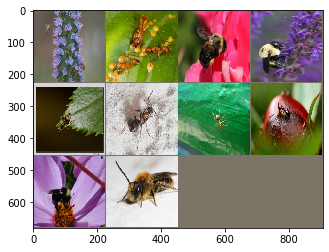

In [60]:
images, labels = next(iter(data_loader['val']))
_, preds = torch.max(model(images.to(device)),1)
grid_img = make_grid(images[:10], nrow=4)
print("label: ",labels[:10])
print("Prediction: ",preds[:10])
imshow(grid_img)